# Summary

# Imports

In [107]:
import concurrent.futures
import itertools
import multiprocessing
import os
import subprocess
import tempfile
from functools import partial
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import sqlalchemy as sa

from kmtools import py_tools, sequence_tools

In [108]:
%matplotlib inline

In [109]:
pd.set_option("max_columns", 100)

# Parameters

In [110]:
NOTEBOOK_PATH = Path('validate_trained_dcn')
NOTEBOOK_PATH

PosixPath('validate_trained_dcn')

In [111]:
OUTPUT_PATH = Path(os.getenv('OUTPUT_DIR', NOTEBOOK_PATH.name)).resolve()
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)
OUTPUT_PATH

PosixPath('/home/kimlab1/database_data/datapkg/adjacency-net-v2/notebooks/validate_trained_dcn')

In [112]:
TASK_ID = os.getenv("SLURM_ARRAY_TASK_ID")
TASK_COUNT = os.getenv("ORIGINAL_ARRAY_TASK_COUNT") or os.getenv("SLURM_ARRAY_TASK_COUNT")

TASK_ID = int(TASK_ID) if TASK_ID is not None else None
TASK_COUNT = int(TASK_COUNT) if TASK_COUNT is not None else None

TASK_ID, TASK_COUNT

(None, None)

In [113]:
DEBUG = "CI" not in os.environ    
DEBUG

True

In [114]:
if DEBUG:
    %load_ext autoreload
    %autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# `DATAPKG`

In [115]:
DATAPKG = {}

In [116]:
DATAPKG['uniparc-domain-wstructure'] = (
    Path(os.environ['DATAPKG_OUTPUT_DIR'])
    .joinpath("uniparc-domain-wstructure", "master")
)

# Run

In [117]:
TRAINING_DATA_DIR = Path("~/tmp/test_pagnn_a1/").expanduser()
TRAINING_DATA_DIR

PosixPath('/home/kimlab1/strokach/tmp/test_pagnn_a1')

## `demo_dataset_1`

In [118]:
DATASET_PATH = Path("demo_datasets/demo_dataset_1").resolve(strict=True)

In [119]:
!python -m pagnn.prediction.dcn_old.main \
    --input-file {DATASET_PATH}/input.parquet \
    --output-file {NOTEBOOK_PATH}/output.parquet \
    --network-info {DATASET_PATH}/network.info \
    --network-state {DATASET_PATH}/network.state

/home/kimlab1/strokach/anaconda/lib/python3.6/runpy.py:125: RuntimeWarning: 'pagnn.prediction.dcn_old.main' found in sys.modules after import of package 'pagnn.prediction.dcn_old', but prior to execution of 'pagnn.prediction.dcn_old.main'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
10it [00:00, 28.39it/s]


In [120]:
output_df = pq.read_table(NOTEBOOK_PATH.joinpath("output.parquet")).to_pandas()

In [121]:
output_df

,predictions
0,0.539994
1,0.577878
2,0.592990
3,0.533424
4,0.544132
5,0.530011
6,0.555791
7,0.446440
8,0.260939
9,0.260939


## Training statistics

In [122]:
list(OUTPUT_DIR.glob('**/*'))

[PosixPath('/home/kimlab1/strokach/tmp/test_pagnn_a1/stats.db'),
 PosixPath('/home/kimlab1/strokach/tmp/test_pagnn_a1/models'),
 PosixPath('/home/kimlab1/strokach/tmp/test_pagnn_a1/models/model_000000041229.state'),
 PosixPath('/home/kimlab1/strokach/tmp/test_pagnn_a1/models/model_000000052950.state'),
 PosixPath('/home/kimlab1/strokach/tmp/test_pagnn_a1/models/model_000000048391.state'),
 PosixPath('/home/kimlab1/strokach/tmp/test_pagnn_a1/models/model_000000050415.state'),
 PosixPath('/home/kimlab1/strokach/tmp/test_pagnn_a1/models/model_000000023699.state'),
 PosixPath('/home/kimlab1/strokach/tmp/test_pagnn_a1/models/model_000000068725.state'),
 PosixPath('/home/kimlab1/strokach/tmp/test_pagnn_a1/models/model_000000071645.state'),
 PosixPath('/home/kimlab1/strokach/tmp/test_pagnn_a1/models/model_000000024760.state'),
 PosixPath('/home/kimlab1/strokach/tmp/test_pagnn_a1/models/model_000000059828.state'),
 PosixPath('/home/kimlab1/strokach/tmp/test_pagnn_a1/models/model_000000076553.s

In [123]:
db_path = TRAINING_DATA_DIR.joinpath("stats.db").resolve(strict=True)
db_path

PosixPath('/home/kimlab1/strokach/tmp/test_pagnn_a1/stats.db')

In [124]:
!ls -lSh /home/kimlab1/strokach/tmp/test_pagnn_a1/stats.db

-rw-r--r-- 1 strokach kimlab 1.3M Sep 27 23:48 /home/kimlab1/strokach/tmp/test_pagnn_a1/stats.db


In [125]:
engine = sa.create_engine(f"sqlite:///{db_path}")

In [126]:
engine.table_names()

['info', 'stats']

### `info_df`

In [127]:
info_df = pd.read_sql_table("info", engine)

In [128]:
display(info_df.head())
print(len(info_df))

,id,step,root_path,training_data_path,validation_data_path,validation_cache_path,learning_rate,beta1,beta2,clamp_lower,clamp_upper,weight_decay,hidden_size,min_seq_length,max_seq_length,batch_size,time_between_checkpoints,time_between_extended_checkpoints,runtime,d_iters,g_iters,training_methods,training_min_seq_identity,training_permutations,validation_methods,validation_min_seq_identity,validation_num_sequences,gpu,tag,array_id,num_aa_to_process,progressbar,num_concurrent_jobs,verbosity
0,0,0,/tmp/strokach/test_pagnn_a1,/home/kimlab1/database_data/datapkg/adjacency-...,/home/kimlab1/database_data/datapkg/adjacency-...,/home/kimlab1/strokach/working/pagnn/pagnn/data,0.00005,0.5,0.999,-0.01,0.01,0.001,64,64,2048,3,60.0,600.0,86313600.0,1,1,permute,0,seq,permute.exact,80,1000,-1,,0,0,True,1,2


1


### `stats_df`

In [129]:
stats_df = pd.read_sql_table("stats", engine)

In [130]:
display(stats_df.head())
print(len(stats_df))

,info_id,step,sequence_number,training_pos-auc,time_between_checkpoints,validation_gan_permute_80_1000-auc,validation_gan_exact_80_1000-auc,pos_preds-mean,neg_preds-mean,pos_losses-mean,neg_losses-mean,model_location,pos_preds,neg_preds,pos_losses,neg_losses
0,0,0,0,1.0,NaN,0.494215,0.48887,0.507283,0.497234,0.680950,0.689767,models/model_000000000000.state,"b""\x80\x04\x95\xc5\x00\x00\x00\x00\x00\x00\x00...",b'\x80\x04\x95\xc5\x00\x00\x00\x00\x00\x00\x00...,b'\x80\x04\x95\x8e\x00\x00\x00\x00\x00\x00\x00...,b'\x80\x04\x95\x8e\x00\x00\x00\x00\x00\x00\x00...
1,0,1,3,0.0,169.524776,NaN,NaN,0.501548,0.509153,0.693797,0.717803,None,b'\x80\x04\x95\xad\x00\x00\x00\x00\x00\x00\x00...,b'\x80\x04\x95\xad\x00\x00\x00\x00\x00\x00\x00...,b'\x80\x04\x95\x8e\x00\x00\x00\x00\x00\x00\x00...,b'\x80\x04\x95\x8e\x00\x00\x00\x00\x00\x00\x00...
2,0,14,42,1.0,65.102949,NaN,NaN,0.518073,0.488425,0.662457,0.675325,None,b'\x80\x04\x95\xb5\x00\x00\x00\x00\x00\x00\x00...,b'\x80\x04\x95\xb5\x00\x00\x00\x00\x00\x00\x00...,b'\x80\x04\x95\x8e\x00\x00\x00\x00\x00\x00\x00...,b'\x80\x04\x95\x8e\x00\x00\x00\x00\x00\x00\x00...
3,0,35,105,0.0,66.618601,NaN,NaN,0.489875,0.497779,0.719322,0.692655,None,b'\x80\x04\x95\xb5\x00\x00\x00\x00\x00\x00\x00...,b'\x80\x04\x95\xb5\x00\x00\x00\x00\x00\x00\x00...,b'\x80\x04\x95\x8e\x00\x00\x00\x00\x00\x00\x00...,b'\x80\x04\x95\x8e\x00\x00\x00\x00\x00\x00\x00...
4,0,52,156,1.0,65.645086,NaN,NaN,0.508703,0.477534,0.680923,0.652061,None,b'\x80\x04\x95\xb5\x00\x00\x00\x00\x00\x00\x00...,b'\x80\x04\x95\xb5\x00\x00\x00\x00\x00\x00\x00...,b'\x80\x04\x95\x8e\x00\x00\x00\x00\x00\x00\x00...,b'\x80\x04\x95\x8e\x00\x00\x00\x00\x00\x00\x00...


1549


In [151]:
stats_df['pos_preds'].apply(pickle.loads).iloc[0]

[array([[[0.529233  , 0.46107668, 0.46573684, 0.50503033, 0.50791866,
          0.46704945, 0.5103783 , 0.4910075 , 0.57594764, 0.5348321 ,
          0.5630106 , 0.4841288 , 0.49932477]]], dtype=float32)]

In [150]:
stats_df['neg_preds'].apply(pickle.loads).iloc[0]

[array([[[0.5290002 , 0.44780627, 0.57400656, 0.51561236, 0.51582277,
          0.48346874, 0.46171272, 0.45759168, 0.501192  , 0.50906247,
          0.49067193, 0.47876915, 0.49932477]]], dtype=float32)]

In [152]:
stats_df['pos_losses'].apply(pickle.loads).iloc[0]

[array(0.6809495, dtype=float32)]

In [158]:
stats_df['neg_losses'].apply(pickle.loads).iloc[0][0].tolist()

0.6897671222686768

In [165]:
def arrays_to_list(arrays):
    ar = np.hstack([ar.reshape(-1) for ar in arrays])
    return ar.tolist()



In [168]:
stats_df['neg_preds'].apply(pickle.loads).apply(arrays_to_list).head()

0    [0.5290002226829529, 0.4478062689304352, 0.574...
1    [0.4420446455478668, 0.47301217913627625, 0.46...
2    [0.4559227228164673, 0.5397010445594788, 0.583...
3    [0.4710617959499359, 0.5322883129119873, 0.536...
4    [0.5251353979110718, 0.4388084411621094, 0.476...
Name: neg_preds, dtype: object

In [169]:
stats_df['neg_losses'].apply(pickle.loads).apply(arrays_to_list)

0          [0.6897671222686768]
1          [0.7178026437759399]
2          [0.6753249764442444]
3           [0.692654550075531]
4          [0.6520606875419617]
5            [0.70010906457901]
6          [0.6639695167541504]
7          [0.7100211977958679]
8          [0.7123652696609497]
9          [0.6862193942070007]
10         [0.6929119825363159]
11         [0.6962013244628906]
12         [0.6820277571678162]
13         [0.7235894799232483]
14         [0.7155508399009705]
15         [0.7061637043952942]
16         [0.7266660332679749]
17         [0.6937105059623718]
18         [0.6732368469238281]
19         [0.6399072408676147]
20         [0.7347503900527954]
21         [0.7146365642547607]
22         [0.6714949607849121]
23         [0.5950021147727966]
24         [0.7891719937324524]
25         [0.7092992067337036]
26         [0.7392634749412537]
27         [0.7492597699165344]
28         [0.7653324007987976]
29          [0.693496584892273]
                 ...           
1519    

In [134]:
import pickle

pickle.loads

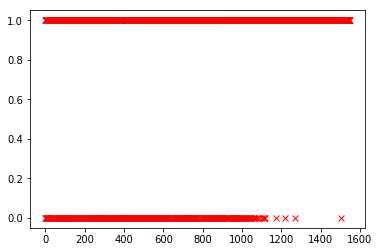

In [131]:
plt.plot(stats_df['training_pos-auc'], 'rx')

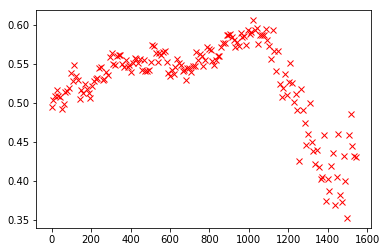

In [132]:
plt.plot(stats_df['validation_gan_permute_80_1000-auc'], 'rx')

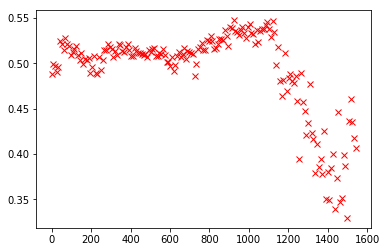

In [133]:
plt.plot(stats_df['validation_gan_exact_80_1000-auc'], 'rx')